
## DS5559 - Project
## Notebook  5 - HCA
#### Name: Mengyao Zhang (mz6jv), Runhao Zhao (rz6dg)

# Synopsis

We investigate similarities among novel chapters (bags) using hieararchical agglomerative clustering (HAC). The essential parameter in this kind of clustering (i.e. vs. flat clustering, such as k-means) is the choice of linkage method. Linkage methods concern the rules by which pairs of coordinates are considered to be part of a group. We use the Ward method, which minimizes the variance among links. 

# Configuration

In [1]:
db_file = 'project.db'
db_name2 = 'tfidf_small.db'

In [2]:
OHCO = ['book_num','chap_num', 'para_num', 'sent_num', 'token_num']
BOOKS = OHCO[:1] 
CHAPS = OHCO[:2]
PARAS = OHCO[:3]
SENTS = OHCO[:4]
#BAG = PARAS 
BAG = CHAPS

# Libraries

In [3]:
import pandas as pd
import numpy as np
import sqlite3

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

# Pragmas

In [3]:
%matplotlib inline

# Process

In [4]:
with sqlite3.connect(db_file) as db:
    bags_meta = pd.read_sql("SELECT * FROM bag", db, index_col='bag_id')
    #tfidf = pd.read_sql("SELECT * FROM tfidf_small", db, index_col=BAG)

In [5]:
# read in tfidf_small
with sqlite3.connect(db_name2) as db2:
    TFIDF = pd.read_sql("SELECT * FROM tfidf_small", db2, index_col=BAG)

In [18]:
TFIDF.head()

95  150  162       296  382       415       417  \
book_num chap_num                                                          
1        0         0.000000  0.0  0.0  0.037412  0.0  0.000000  0.046796   
         1         0.000000  0.0  0.0  0.027259  0.0  0.034097  0.000000   
         2         0.019922  0.0  0.0  0.000000  0.0  0.000000  0.000000   
         3         0.000000  0.0  0.0  0.014575  0.0  0.036462  0.000000   
         4         0.000000  0.0  0.0  0.000000  0.0  0.000000  0.000000   

                        420  447       461  ...       44700  44804  44819  \
book_num chap_num                           ...                             
1        0         0.000000  0.0  0.000000  ...    0.000000    0.0    0.0   
         1         0.000000  0.0  0.027512  ...    0.000000    0.0    0.0   
         2         0.000000  0.0  0.043675  ...    0.000000    0.0    0.0   
         3         0.020038  0.0  0.000000  ...    0.019656    0.0    0.0   
         4         0.039071  0.0  0.028683  ...    0.000000    0.0    0.0   

                      44825     44833     44857     44860     44864     44911  \
book_num chap_num                                                               
1        0         0.000000  0.098101  0.000000  0.000000  0.047139  0.025306   
         1         0.000000  0.047653  0.020395  0.000000  0.051520  0.036877   
         2         0.022621  0.018912  0.064753  0.030207  0.054525  0.043907   
         3         0.000000  0.025479  0.010905  0.000000  0.009182  0.039435   
         4         0.000000  0.024841  0.042525  0.000000  0.035808  0.019223   

                   44929  
book_num chap_num         
1        0           0.0  
         1           0.0  
         2           0.0  
         3           0.0  
         4           0.0  

[5 rows x 984 columns]

In [21]:
TFIDF.shape

(1593, 984)

In [ ]:
#import numpy as np
np.array(TFIDF)

In [1]:
#TFIDF.columns = TFIDF.columns.droplevel(0)

## Get labels for the display

#### Get book_ids

In [7]:
books = TFIDF.reset_index().book_num
books_list = books.unique().tolist()
book_ids = books.apply(lambda x: books_list.index(x)).values

In [8]:
book_ids

array([ 0,  0,  0, ..., 29, 29, 29])

In [9]:
len(book_ids)

1593

#### Get author_ids

In [10]:
bags_meta_new = bags_meta.drop_duplicates(['book_num','chap_num'])
tfidf_idx = TFIDF.reset_index()[['book_num','chap_num']]
new_df = tfidf_idx.merge(bags_meta_new,how="left",on=['book_num','chap_num']).drop('para_num',1)
authors = new_df.author
author_list = authors.unique().tolist()
author_ids = authors.apply(lambda x: author_list.index(x)).values
author_name = new_df.author.values

In [22]:
len(author_ids)

1593

In [11]:
len(author_name)

1593

In [6]:
#labels = bags.apply(lambda x: ' '.join(x.astype('str')), 1).tolist()

## Generate Similarity Pairs

`pdist()` will generate all pairs of terms where ` i < j < m`. To access individual pairs by named, we'd generate an index to go with it, e.g. `pair_idx = [(i, j) for i in TFIDF.index for j in TFIDF.index if j > i]`. Earlier, we created these pairs by hand and applied various distance measures to them. The `pdist()` function is much faster and should be used in production.

In [12]:
SIMS = pdist(TFIDF, metric='cosine')

In [15]:
len(SIMS)

1268028

## Generate the Dendrogram

We use the Ward linkage method.

In [13]:
TREE = sch.linkage(SIMS, method='ward')

In [16]:
TREE

array([[7.91000000e+02, 8.38000000e+02, 7.19786451e-02, 2.00000000e+00],
       [1.34600000e+03, 1.35500000e+03, 1.12710839e-01, 2.00000000e+00],
       [1.36700000e+03, 1.59400000e+03, 1.23780880e-01, 3.00000000e+00],
       ...,
       [3.16400000e+03, 3.16800000e+03, 3.59322668e+00, 3.80000000e+02],
       [3.18000000e+03, 3.18100000e+03, 4.64875867e+00, 1.21300000e+03],
       [3.18200000e+03, 3.18300000e+03, 5.54502818e+00, 1.59300000e+03]])

In [17]:
TREE.shape

(1592, 4)

## Plot the tree

In [18]:
def plot_tree(tree, labels):
    plt.figure()
    fig, axes = plt.subplots(figsize=(15, 300))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left")
    plt.tick_params(axis='both', which='major', labelsize=10)

<Figure size 432x288 with 0 Axes>

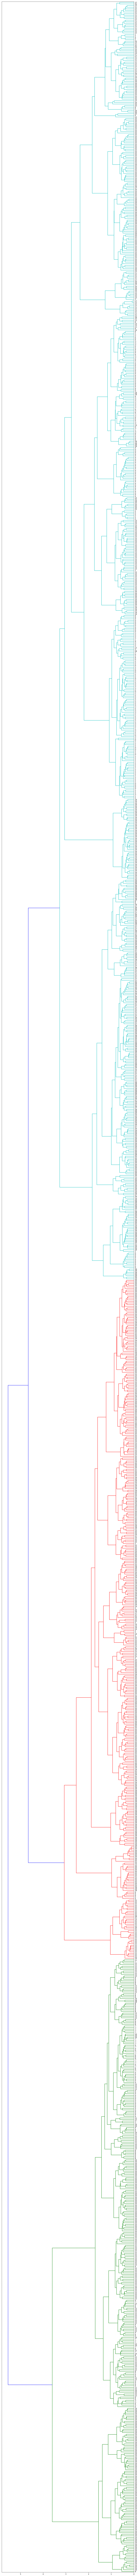

In [19]:
plot_tree(TREE, book_ids)

<Figure size 432x288 with 0 Axes>

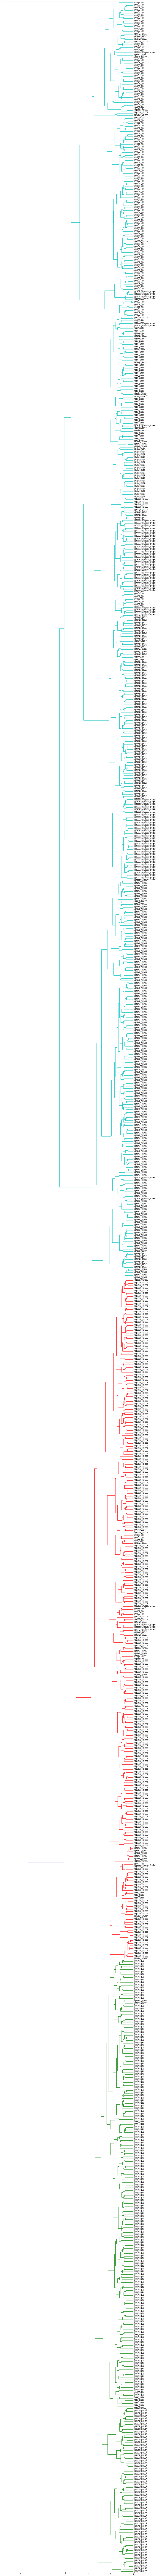

In [23]:
plot_tree(TREE, author_name)